# Introduction

Hi Kagglers,

This is a supplementary notebook to the Kiva Data Science for Good challenge. The results of this notebook are used in the [Kiva Philippines Poverty Score notebook](https://www.kaggle.com/rossrco/kiva-philippines-poverty-score).

In this notebook, we'll match the region from the `kiva_loans.csv` dataset to a region in the Philippines.

# Data Transformation Description

The `kiva_loans.csv` dataset contains a `region` column. The data in this column represents a written description of the borrower's location. The issue we are trying to solve here is that:

* Sometimes the column represents the name of a city followed by the name of its corresponding province
* Sometimes the column represents the name of a major city in the region and has no reference to the province
* Sometimes the column represents the name of small cities or villages that are not administrative centers and are hard to locate

From the onset, we'll tackle this challenge only for the Philippines region as it is the region of concern in the [main notebook](https://www.kaggle.com/rossrco/kiva-philippines-poverty-score). In light of this, it would be useful to mention the structure and hierarchy of the Filippino administrative regions:

1. Island Group
2. Region
3. Province
4. City

In the most common case, the `region` column of the `kiva_loans.csv` dataset contains patterns of the type: 'city name, province'. In some rare cases the the `region` column contains patterns of the type: 'city name'. We'll use these patterns to match either the city or the province to a region. To do that, we'll utilize a small dataset of island groups, regions, provinces and cities based on [this wikipedia article](https://en.wikipedia.org/wiki/Administrative_divisions_of_the_Philippines).

Finally, we should mention that through these heueristics, we managed to map 150 000 out of 160 000 loan locations. The rest 10 000 could be matched in the future through other methods (e.g. Google Maps API, etc.).

In [8]:
#numeric
import numpy as np
import pandas as pd

#visualization
import matplotlib.pyplot as plt
import seaborn as sns
import folium

plt.style.use('bmh')
%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['axes.titlepad'] = 25
sns.set_color_codes('pastel')

#system
import os
import re

#Pandas warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
#load the kiva loans and the Philippine regions data sets
loans = pd.read_csv('kiva_loans.csv')
phil_loans = loans[loans.country == 'Philippines']
geonames_phil = pd.read_csv('ph_regions.csv')

from difflib import get_close_matches

def match_region(loc_string, match_entity = 'province', split = True):
    #split the location string by comma
    #the location string contains (most frequently) city and province
    if split == True:
        region = loc_string.split(',')[-1]
    else:
        region = loc_string
    
    #get close matches for the province from the matching table
    matches = get_close_matches(region, geonames_phil[match_entity].unique().tolist())
    
    #return the region corresponding to the first matched province
    if not matches:
        return 'no_match'
    else:
        return geonames_phil.region[geonames_phil[match_entity] == matches[0]].iloc[0]

phil_loans.region.fillna('', inplace = True)
phil_loans.rename(columns = {'region' : 'location'}, inplace = True)
phil_loans['region'] = [match_region(loc_string) for loc_string in phil_loans.location]

#remove the word 'city' from the location strings that were not matched by the <city><province> pattern
city_drop = re.compile(r'(.*)(city)', re.I)
phil_loans.location[phil_loans.region == 'no_match'] = [re.match(city_drop, l).group(1).lower()\
                                                        if re.match(city_drop, l)\
                                                        else l for l\
                                                        in phil_loans.location[phil_loans.region == 'no_match']]

#try to match the unmatched locations to cities
phil_loans['region'][phil_loans.region == 'no_match'] = np.vectorize(match_region)(phil_loans['location'][phil_loans.region == 'no_match'], 'city', False)

#try to match the unmatched locations to Sogod Cebu - one of the frequently-appearing cities
phil_loans.region[phil_loans.location == 'Sogod Cebu'] = geonames_phil.region[geonames_phil.city == 'cebu'].iloc[0]

phil_loans_extract = phil_loans[(phil_loans.borrower_genders.notnull()) & (phil_loans.region != 'no_match')]

#one hot encode the borrower gender and rename the column to house_head_sex_f
phil_loans_extract['borrower_genders'] = phil_loans_extract['borrower_genders']\
.map({'female' : 1,\
      'male' : 0})

phil_loans_extract.rename(columns = {'borrower_genders' : 'house_head_sex_f'}, inplace = True)


In [4]:
phil_loans_extract.head()

,id,funded_amount,loan_amount,activity,sector,use,country_code,country,location,currency,...,posted_time,disbursed_time,funded_time,term_in_months,lender_count,tags,house_head_sex_f,repayment_interval,date,region
52,653149,175.0,175.0,Pigs,Agriculture,to purchase feed and vitamins for her pigs,PH,Philippines,"Tanjay, Negros Oriental",PHP,...,2014-01-02 04:18:30+00:00,2013-12-06 08:00:00+00:00,2014-01-02 07:47:28+00:00,8.0,7,NaN,1,irregular,2014-01-02,central visayas
55,653123,700.0,700.0,General Store,Retail,"to buy additional items like eggs, charcoal, r...",PH,Philippines,"Brookes Point, Palawan",PHP,...,2014-01-02 02:18:02+00:00,2013-12-10 08:00:00+00:00,2014-01-02 03:26:10+00:00,5.0,2,NaN,1,irregular,2014-01-02,mimaropa
56,653338,575.0,575.0,Farming,Agriculture,to purchase fertilizers and other farm supplies,PH,Philippines,"Tanjay, Negros Oriental",PHP,...,2014-01-02 13:38:42+00:00,2013-12-05 08:00:00+00:00,2014-01-02 23:01:23+00:00,8.0,19,NaN,1,irregular,2014-01-02,central visayas
65,653242,325.0,325.0,General Store,Retail,"to purchase sugar, coffee, coffee creamer, can...",PH,Philippines,"Sinippil, Cauayan City, Isabela",PHP,...,2014-01-02 09:13:05+00:00,2013-12-13 08:00:00+00:00,2014-01-02 17:50:06+00:00,7.0,11,volunteer_pick,1,irregular,2014-01-02,cagayan valley
72,653134,575.0,575.0,Pigs,Agriculture,to purchase additional feed for her pigs.,PH,Philippines,"Brookes Point, Palawan",PHP,...,2014-01-02 02:58:01+00:00,2013-12-09 08:00:00+00:00,2014-01-02 14:47:08+00:00,8.0,20,NaN,1,irregular,2014-01-02,mimaropa


Text(0.5,1,'Distribution of Derived Borrower Gender')

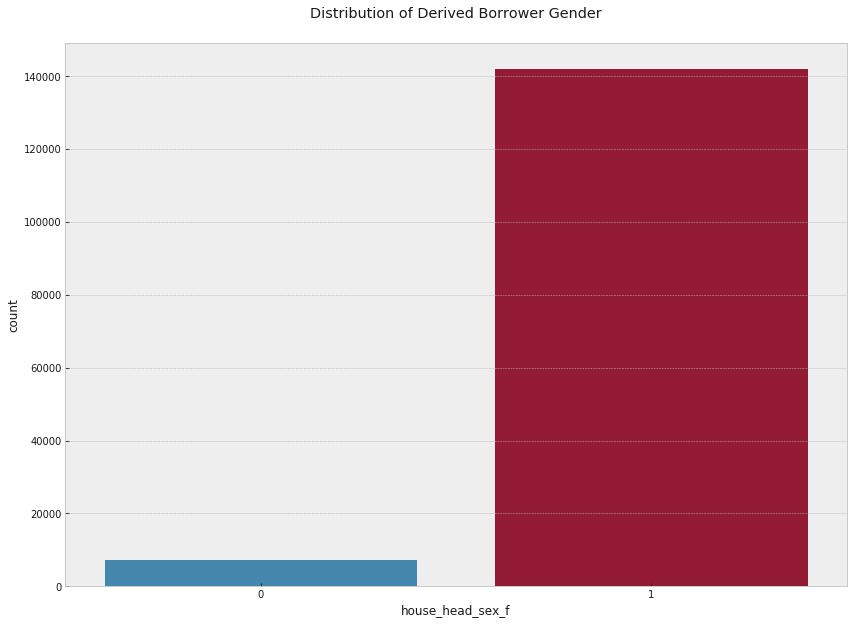

In [10]:
sns.countplot(phil_loans_extract.house_head_sex_f)
plt.title('Distribution of Derived Borrower Gender')

Text(0.5,1,'Distribution of Loans per Region')

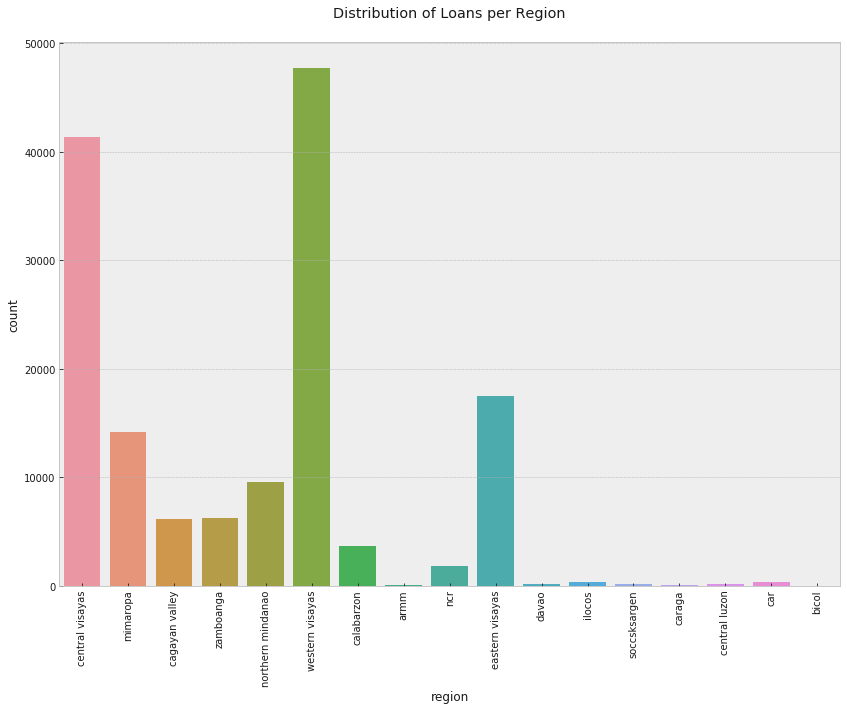

In [13]:
sns.countplot(phil_loans_extract.region)
plt.xticks(rotation = 90)
plt.title('Distribution of Loans per Region')

Text(0.5,1,'Loan Amount Distribution')

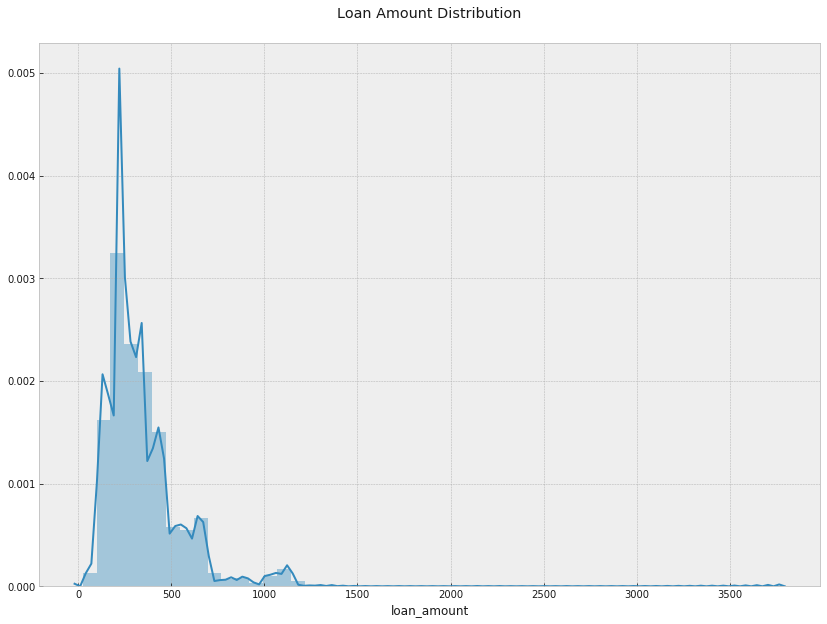

In [16]:
sns.distplot(phil_loans_extract[phil_loans_extract.loan_amount < 4000].loan_amount)
plt.title('Loan Amount Distribution')

In [11]:
phil_loans_extract.to_csv('kiva_loans_ph_transofrmed.csv')